## Imports

In [77]:
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from tabulate import tabulate

np.random.seed(13)

## Main

### Task - 3

In [78]:
data = np.load('./Utils/rolls.npy')

#### Part - 1

In [79]:
midpoint = len(data)//2
train, valid = data[:midpoint], data[midpoint:]

##### Part - 1.1

In [80]:
num_sets = 1000
num_outcomes = 6

unfair_probabilities = np.random.dirichlet(np.ones(num_outcomes), size=num_sets)
fair_probabilties = np.full((num_sets, num_outcomes), 1/6)

emission_probabilities = np.zeros((num_sets, 2, num_outcomes))
emission_probabilities[:, 0, :] = fair_probabilties
emission_probabilities[:, 1, :] = unfair_probabilities

100%|██████████| 1000/1000 [01:42<00:00,  9.71it/s]


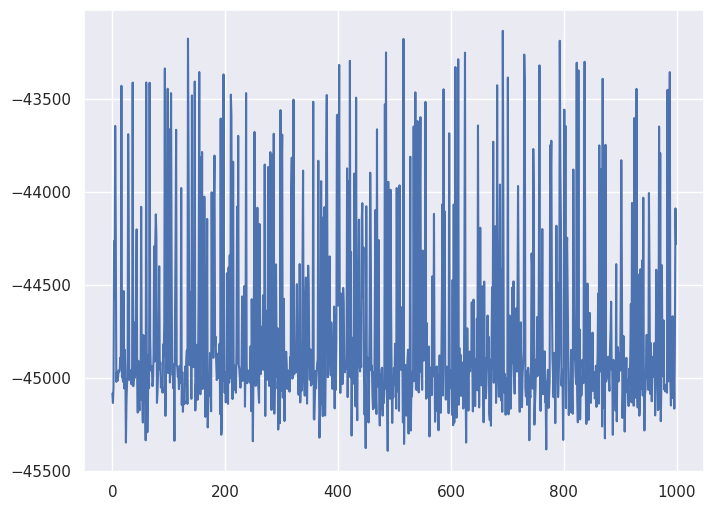

In [81]:
best_score, best_emission = -np.inf, None

scores = []

for emission in tqdm(emission_probabilities):
    startprob = np.array([1.0, 0.0])
    model = hmm.CategoricalHMM(n_components=2, random_state=13, init_params='tmc', params='t')
    model.emissionprob_ = emission
    model.startprob_ = startprob
    model.fit(train)
    score = model.score(valid)
    if(best_score < score):
        best_score = score
        best_emission = model

    scores.append(score)

plt.plot(scores)
plt.show()

I have set `init_params = 'tmc'` to specify initial values for the emission probability and start probability. This choice prevents the model from re-initializing these parameters, preserving the values I've defined. Additionally, I use `params = 't'` to exclude training on the start probability and emission probability. The rationale behind this is twofold:

1. *Known Start Probability:*
   We are already aware of the start probability (given in the question to assume the sequence starts with a fair die). Therefore, training the model on this known parameter is unnecessary.

2. *Fixing Fair Die, Adjusting Loaded Die:*
   Our objective is to maintain a uniform distribution for the fair die while adjusting the emission probability of the loaded die. By setting `params = 't'`, we ensure that the model training does not update our emission probabilities, as we already possess information about one die being fair. The goal is to determine the optimal emission probability for the loaded die by iterating over 1000 randomly generated possibilities and selecting the best fit.

In [82]:
print("The best model obtained out of the various emission probabilities that we have tried is:")
print("Starting Probability : ", best_emission.startprob_)
print("Transmission Probability : \n", best_emission.transmat_)
print("Emission Probability : \n", best_emission.emissionprob_)

The best model obtained out of the various emission probabilities that we have tried is:
Starting Probability :  [1. 0.]
Transmission Probability : 
 [[0.80702549 0.19297451]
 [0.65529361 0.34470639]]
Emission Probability : 
 [[1.66666667e-01 1.66666667e-01 1.66666667e-01 1.66666667e-01
  1.66666667e-01 1.66666667e-01]
 [8.02878600e-02 3.08985440e-02 5.53396490e-02 5.77652837e-04
  3.44413792e-02 7.98454915e-01]]


##### Part - 1.2

In the predicted states array, we have 50,000 value which correspond to which die was used at which timestep. 0 Corresponds to the Fair Die and 1 corresponds to the Loaded Die.

In [83]:
predicted_states = model.predict(data)
len(predicted_states.nonzero()[0])

22404

##### Part - 1.3

Visualization is provided for the first 100 most likely predicted states. Attempting to plot all 50,000 points in a single graph was deemed impractical and counterproductive, as it would compromise analyzability.

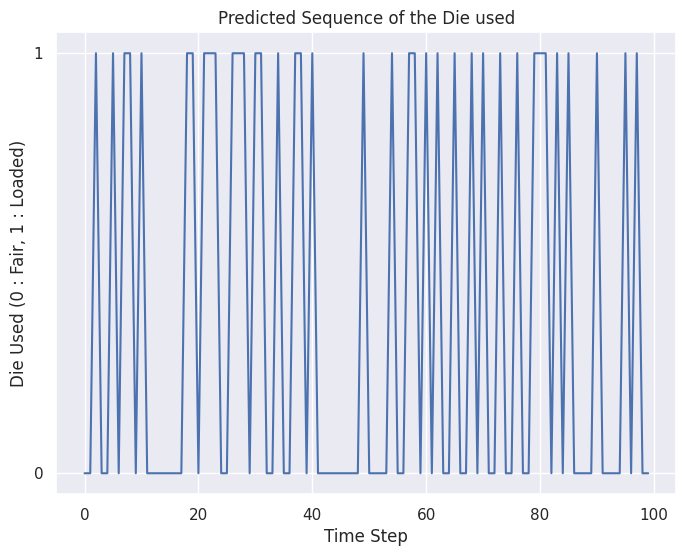

In [84]:
plotting_states = predicted_states[:100]


# plt.figure(figsize=(10, 6))
plt.plot(range(len(plotting_states)), plotting_states)
plt.xlabel('Time Step')
plt.ylabel('Die Used (0 : Fair, 1 : Loaded)')
plt.title('Predicted Sequence of the Die used')
plt.yticks([0, 1])
plt.show()

##### Part - 1.4

This task corresponds to the `Decoding` problem in Hidden Markov models.<br>
This is because we are being asked to predict the sequeunce of dies used, we are basically trying to figure out which part of the sequence was generated by the loaded die and which part was generated by the fair die.

#### Part - 2

##### Part - 2.1

In [85]:
# analyzing the transition matrix
print("The transition matrix obtained is:", best_emission.transmat_)

The transition matrix obtained is: [[0.80702549 0.19297451]
 [0.65529361 0.34470639]]


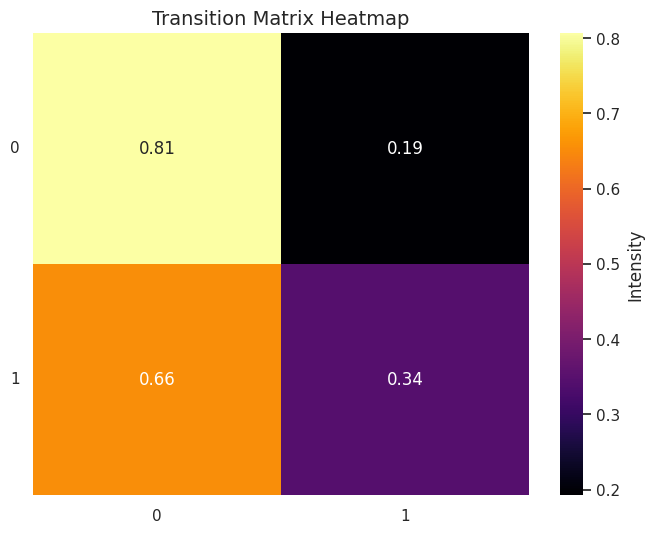

In [86]:
sns.heatmap(best_emission.transmat_, cmap="inferno", annot=True, cbar_kws={'label': 'Intensity'})
plt.title("Transition Matrix Heatmap", fontsize=14)
plt.yticks(rotation=0)
plt.show()

In this transition matrix, the cells represent the following:
- (0,0) : Probability of `staying` at `Fair Die` given that current die is `Fair`
- (0,1) : Probability of `changing` to `Loaded Die` given that current die is `Fair`
- (1,0) : Probability of `changing` to `Fair Die` given that current die is `Loaded`
- (1,1) : Probability of `staying` at `Loaded Die` given that current die is `Loaded`

Hence, to answer the question asked:

In [87]:
print("The casino is switching out the fair die for the loaded one with a probability of\n" + str(best_emission.transmat_[0][1]) + "\nand it's switching out the loaded die for the fair one with a probability of\n" + str(best_emission.transmat_[1][0]) + "\nas per our findings.")

The casino is switching out the fair die for the loaded one with a probability of
0.192974512627527
and it's switching out the loaded die for the fair one with a probability of
0.6552936119466622
as per our findings.


##### Part - 2.2

This task corresponds to the `Learning` problem in Hidden Markov models.<br>
This is because we are being asked to find how often does the casino player change from fair to loaded, which corresponds to the Learning question in HMMs.

#### Part - 3

##### Part - 3.1

In [88]:
# analyzing the emission probability of the loaded die

print("The emission probability of the loaded die is:\n", best_emission.emissionprob_[1])

The emission probability of the loaded die is:
 [8.02878600e-02 3.08985440e-02 5.53396490e-02 5.77652837e-04
 3.44413792e-02 7.98454915e-01]


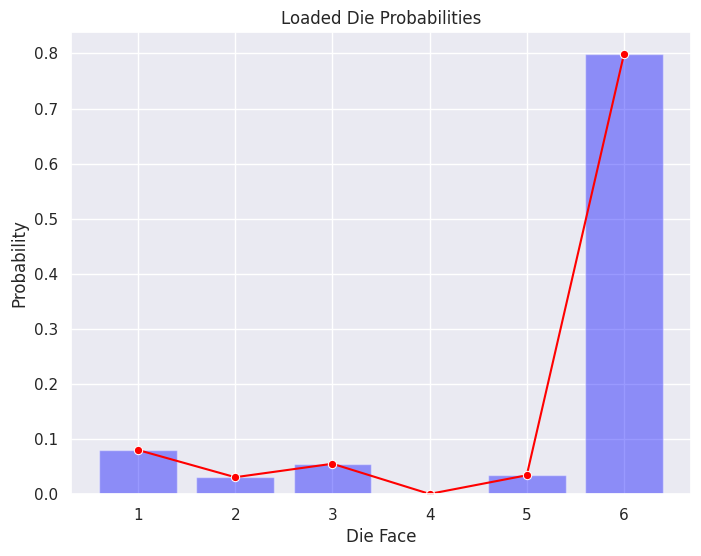

In [89]:
probabilities = best_emission.emissionprob_[1]
faces = np.arange(1, len(probabilities) + 1)
sns.lineplot(x=faces, y=probabilities, marker='o', color='red')
plt.bar(faces, probabilities, color='blue', alpha=0.4)
plt.xlabel('Die Face')
plt.ylabel('Probability')
plt.title('Loaded Die Probabilities')
plt.show()

In [90]:
# data in table form for exact observation
obs = []

for i in range(6):
    obs.append([i+1, best_emission.emissionprob_[1][i]])
headers = ["Die Face", "Probability"]
table = tabulate(obs, headers, tablefmt="fancy_grid")
print(table)

╒════════════╤═══════════════╕
│   Die Face │   Probability │
╞════════════╪═══════════════╡
│          1 │   0.0802879   │
├────────────┼───────────────┤
│          2 │   0.0308985   │
├────────────┼───────────────┤
│          3 │   0.0553396   │
├────────────┼───────────────┤
│          4 │   0.000577653 │
├────────────┼───────────────┤
│          5 │   0.0344414   │
├────────────┼───────────────┤
│          6 │   0.798455    │
╘════════════╧═══════════════╛


##### Part - 3.2

This task aligns with the 'Learning' aspect of Hidden Markov Models (HMMs). We are tasked with determining the degree of bias in the loaded die, essentially addressing the Learning question within the context of HMMs.

### Task - 4

In [91]:
data = np.load('./Utils/runs.npy')
data[data == 6] = 5
playerlist = ["Virat", "Rohit"]

Given our approximate knowledge of the percentage change in strike after each ball, we employ the Dirichlet function. Specifically, we set alpha to [0.7, 0.3] for the first row of the transition matrix and [0.3, 0.7] for the second row. This choice aims to impose a probability distribution aligned with our pre-existing understanding.

Given the information that Virat is inclined towards taking singles and doubles, we set the alpha for the Dirichlet function as follows:

`[2, 3, 3, 1, 1, 0.5]` for the outcomes `0`, `1`, `2`, `3`, `4`, and `6`.

This choice in alpha values is guided by the assumption that Virat, as an anchor in the innings, opts for less risky shots, emphasizing singles and doubles. Threes are generally uncommon, and dot balls are more frequent than boundaries but less so than singles and doubles.

Likewise, for Rohit, I've chosen the following alpha values for the Dirichlet function:

`[2, 1, 0.5, 0.25, 3, 3]` for the outcomes `0`, `1`, `2`, `3`, `4`, and `6`.

This assumption assigns greater weight to risky shots, progressively reducing the weight for shots that involve running between the wickets.

Since we don't have any information about who started the game, we take the alpha to be `[0.5, 0.5]`.

In [92]:
percentage_change = np.array([np.random.dirichlet([0.7, 0.3]),
        np.random.dirichlet([0.3, 0.7])])
percentage_change

array([[0.84687601, 0.15312399],
       [0.39103117, 0.60896883]])

100%|██████████| 10000/10000 [00:51<00:00, 195.14it/s]


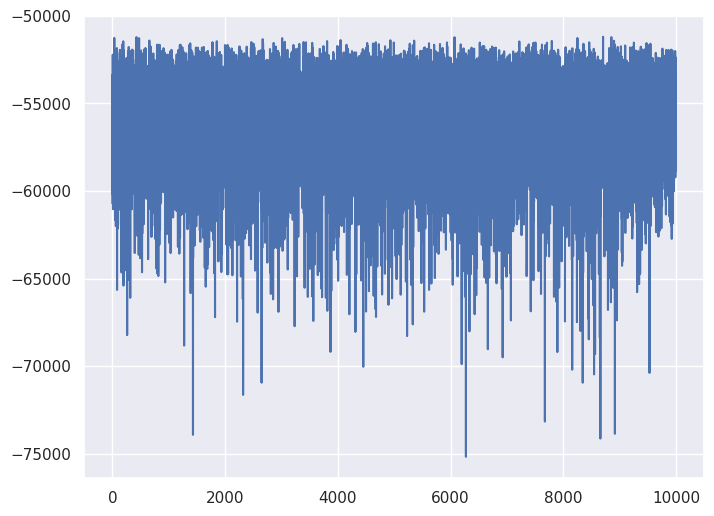

In [93]:
best_score, best_model = -np.inf, None

scores = []

for i in tqdm(range(10000)):
    model = hmm.CategoricalHMM(n_components=2, random_state=42, init_params='mc')
    model.transmat_ = np.array([np.random.dirichlet([7, 3]),
        np.random.dirichlet([3, 7])])
    model.emissionprob_ = np.array([np.random.dirichlet([2, 3, 3, 1, 1, 0.5]),
        np.random.dirichlet([2, 1, 0.5, 0.5, 3, 3])])
    model.startprob_ = np.random.dirichlet([0.5, 0.5])
    score = model.score(data)
    if(best_score < score):
        best_score = score
        best_model = model

    scores.append(score)

plt.plot(scores)
plt.show()

In [94]:
print("Optimal Transition Probability is:\nVirat:", best_model.transmat_[0], "\nRohit:", best_model.transmat_[1])
# sns.set(rc={'figure.figsize': (8, 6)})
# sns.heatmap(best_model.transmat_, cmap="inferno", annot=True, cbar_kws={'label': 'Intensity'})
# plt.title("Transition Matrix Heatmap", fontsize=14)
# plt.yticks(rotation=0)
# plt.xticks([0, 1], ['Virat', 'Rohit'])
# plt.show()

print()
print("Optimal Emission Probability is:\nVirat:", best_model.emissionprob_[0], "\nRohit:", best_model.emissionprob_[1])
print()
print("Optimal Start Probability is:\nVirat:", best_model.startprob_[0], "\nRohit:", best_model.startprob_[1])

Optimal Transition Probability is:
Virat: [0.68619435 0.31380565] 
Rohit: [0.50926748 0.49073252]

Optimal Emission Probability is:
Virat: [0.0899998  0.25707826 0.32129809 0.06049948 0.21691913 0.05420524] 
Rohit: [1.93150811e-01 1.15901793e-01 3.83170212e-05 4.21903275e-03
 3.46165960e-01 3.40524086e-01]

Optimal Start Probability is:
Virat: 0.8746664922118355 
Rohit: 0.12533350778816457


In [95]:
best_model = best_model.fit(data)

In [96]:
predicts = best_model.predict(data)
predicts

array([0, 1, 1, ..., 0, 1, 0])

In [97]:
obs = []
obs.append(["First Ball of the game", playerlist[predicts[0]]])
obs.append(["Last Ball of the game", playerlist[predicts[-1]]])
table = tabulate(obs, tablefmt="fancy_grid")
print(table)

╒════════════════════════╤═══════╕
│ First Ball of the game │ Virat │
├────────────────────────┼───────┤
│ Last Ball of the game  │ Virat │
╘════════════════════════╧═══════╛
